### This program serves to build a Radiative Convective model as part of Climate Dynamics assignment 3.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [74]:
# variables we have to play with:
z = 10*1000 #m 

# listing of variables:
So = 240 # top of atmosphere radiation (W m−2)
tau_inf = 2.8
rho_0 = 1.225 # density of air at sea level (kg m-3)
h = 3*1000 # m 
sigma = 5.67e-8 #Wm−2K−4
LR = 0.6 * (-9.81/1004) #K m−1
k = 37.0 # Wm−2K−1
Cp = 1004 # J kg−1K−1
H = 8*1000 #m 
rho = rho_0*np.exp(-z/H)
npts = 11
g = 9.81 # m/s-2 

In [4]:
# step 1 
tau_M = tau_inf*(1 - np.exp(-z/h))
tau_M

2.700112818627693

In [199]:
# step 2 
Fd_m = So*(0.5*(tau_inf - tau_M))
Fd_m

11.986461764676815

In [190]:
# step 3 
taus = np.linspace(0, tau_M, 11)
taus

array([0.        , 0.27001128, 0.54002256, 0.81003385, 1.08004513,
       1.35005641, 1.62006769, 1.89007897, 2.16009025, 2.43010154,
       2.70011282])

In [194]:
# step 4
zs = -h*(np.log(1 - (taus/tau_inf)))
zs

array([   -0.        ,   304.21372106,   642.79376369,  1024.50535927,
        1461.96409077,  1974.28429344,  2592.48703726,  3372.05065193,
        4428.14265912,  6072.43845563, 10000.        ])

In [196]:
# step 5
T_RE = ((So/sigma)*(0.5*(tau_inf*np.exp(-zs/h)) + 0.5))**(1/4)
T_RE

array([299.46456866, 293.99698465, 288.20611774, 282.04351264,
       275.44822077, 268.34194792, 260.62153528, 252.14676424,
       242.71942436, 232.04469359, 219.65271816])

In [198]:
# step 6
T_RCE = T_RE[-1] + LR*(zs-zs[-1])
T_RCE

array([278.27821616, 276.49474807, 274.50980571, 272.27200247,
       269.70737887, 266.70387617, 263.0796318 , 258.50940129,
       252.3180093 , 242.67824331, 219.65271816])

In [213]:
# step 7 
Fd = []
for m in range(len(taus)):
    test_sum = Fd_m*np.exp(taus[m] - taus[-1]) 
    for j in range(m,10):
        test_sum += 0.5*(sigma*T_RCE[j]**4 * np.exp(taus[m] - taus[j]) + sigma*T_RCE[j+1]**4 * np.exp(taus[m] - taus[j+1])) * (taus[j+1] - taus[j])
    Fd.append(test_sum)    
#Fd.append(Fd_m)
Fd

[288.5573952849865,
 273.13211638004265,
 255.72306887854103,
 235.98263519124538,
 213.51999156373574,
 187.9159054361237,
 158.76216083115983,
 125.7558105398632,
 88.92921331749068,
 49.30218028105156,
 11.986461764676815]

In [214]:
# step 8 
T_b = (So + Fd[0] - (sigma*(T_RCE[0]**4)))/(4 * sigma * (T_RCE[0]**3) + k) + T_RCE[0]  
T_b

282.7793507426883

In [215]:
# step 9 
Fu_sfc = sigma*(T_RCE[0]**4) + (4*sigma*(T_RCE[0]**3))*(T_b - T_RCE[0])
Fu_sfc

362.0154158757774

In [222]:
# step 10 
Fu = []
#test_sum_Fu = Fu_sfc*np.exp(-taus)
for m in reversed(range(len(taus))):
    test_sum_Fu = Fu_sfc*np.exp(-1*taus[m])
    for j in range(m):
        test_sum_Fu += 0.5*(sigma*(T_RCE[j]**4) * np.exp(taus[j] - taus[m]) + sigma*(T_RCE[j+1]**4) * np.exp(taus[j+1] - taus[m])) * (taus[j+1] - taus[j])
    Fu.append(test_sum_Fu)
Fu = Fu[::-1]
Fu

[362.0154158757774,
 356.1325214503853,
 349.48102801550993,
 342.033119519753,
 333.71602532794697,
 324.39969386937776,
 313.8706779890539,
 301.7761785012528,
 287.48942302510835,
 269.69514063008455,
 243.96354269599072]

In [224]:
# step 11 
Fu_RE = So*(0.5*(tau_inf - taus[-1]) + 1)
Fu_RE

251.98646176467682

In [225]:
# step 12 - check for error
error = Fu[-1] - Fu_RE
error

-8.022919068686093

In [8]:
def get_error2(x):
    tau_M = tau_inf*(1 - np.exp(-x/h))
    Fd_m = So*(0.5*(tau_inf - tau_M))
    taus = np.linspace(0, tau_M, 101)
    zs = -h*(np.log(1 - (taus/tau_inf)))
    T_RE = ((So/sigma)*(0.5*(tau_inf*np.exp(-zs/h)) + 0.5))**(1/4)
    T_RCE = T_RE[-1] + LR*(zs-zs[-1])
    Fd = []
    for m in range(len(taus)):
        test_sum = Fd_m*np.exp(taus[m] - taus[-1]) 
        for j in range(m,100):
            test_sum += 0.5*(sigma*T_RCE[j]**4 * np.exp(taus[m] - taus[j]) + sigma*T_RCE[j+1]**4 * np.exp(taus[m] - taus[j+1])) * (taus[j+1] - taus[j])
        Fd.append(test_sum)
    T_b = (So + Fd[0] - (sigma*(T_RCE[0]**4)))/(4 * sigma * (T_RCE[0]**3) + k) + T_RCE[0]  
    Fu_sfc = sigma*(T_RCE[0]**4) + (4*sigma*(T_RCE[0]**3))*(T_b - T_RCE[0])
    Fu = []
    for m in reversed(range(len(taus))):
        test_sum_Fu = Fu_sfc*np.exp(-1*taus[m])
        for j in range(m):
            test_sum_Fu += 0.5*(sigma*(T_RCE[j]**4) * np.exp(taus[j] - taus[m]) + sigma*(T_RCE[j+1]**4) * np.exp(taus[j+1] - taus[m])) * (taus[j+1] - taus[j])
        Fu.append(test_sum_Fu)
    Fu = Fu[::-1]
    Fu_RE = So*(0.5*(tau_inf - taus[-1]) + 1)
    #Fd_RE = So*(0.5*(tau_inf - taus))
    error = Fu[-1] - Fu_RE
    
    #return(error)
    return(error,taus,zs,T_RE,T_RCE,Fd,Fu)

In [ ]:
get_error2(10000)  

In [9]:
a = 8000
b = 13000

c = a 
while ((b-a) >= 0.0001): 

    # Find middle point 
    c = (a+b)/2

    # Check if middle point is root 
    if (get_error2(c)[0] == 0.0): 
        break

    # Decide the side to repeat the steps 
    if (get_error2(c)[0]*get_error2(a)[0] < 0): 
        b = c 
    else: 
        a = c 

print("The value of root is : ","%.4f"%c) 
error,taus,zs,T_RE,T_RCE,Fd,Fu  = get_error2(c)

The value of root is :  10388.4445


In [232]:
len(zs)

11

In [10]:
new_zs = np.linspace(10388.4445, 16000, 100)
new_tau = tau_inf*(1 - np.exp(-new_zs/h))
Fu_new_zs = So*(0.5*(tau_inf - new_tau) + 1)
Fd_new_zs = So*(0.5*(tau_inf - new_tau))
T_m_new_zs = ((So/sigma)*(0.5*(tau_inf*np.exp(-new_zs/h)) + 0.5))**(1/4)
T_m_adj_new_zs = T_m_new_zs[-1] + LR*(new_zs-new_zs[-1])

In [11]:
len(T_m_new_zs)

100

In [12]:
# now we have to append our Fd_new_zs and Fu_new_zs to our Fd_int and Fu_int respectively. 
RCE_zs = np.concatenate([zs, new_zs])
Fu_zs = np.concatenate([Fu, Fu_new_zs])
Fd_zs = np.concatenate([Fd, Fd_new_zs])
T_m_new_zs_test = np.concatenate([T_RE, T_m_new_zs ])
T_m_adj_new_zs = np.concatenate([T_RCE, T_m_new_zs ])

In [13]:
len(T_m_adj_new_zs)

201

Okay, so Fd_zs and Fu_zs are the RCE solutions below the BL with the RE solution above the BL.
Now need to calculate RE for full atmospheric profile.

In [14]:
# RE profile
RE_zs = np.linspace(0, 16000, 201)
RE_tau = tau_inf*(1 - np.exp(-RE_zs/h))
Fu_RE_zs = So*(0.5*(tau_inf - RE_tau) + 1)
Fd_RE_zs = So*(0.5*(tau_inf - RE_tau))
T_m_RE_zs = ((So/sigma)*(0.5*(tau_inf*np.exp(-RE_zs/h)) + 0.5))**(1/4)
T_m_adj_RE_zs = T_m_RE_zs[-1] + LR*(RE_zs-RE_zs[-1])

In [15]:
len (Fd_RE_zs)

201

In [18]:
len(RCE_zs)

201

In [19]:
RCE_zs.max()

16000.0

In [20]:
## Q_R

In [21]:
rho = rho_0*np.exp(-zs/H)

In [22]:
#Q_R = []
#for j in range(0, len(RCE_zs)-1):
#    testing = ((Fd_int_plot[j] - Fu_int_plot[j])*(Fd_int_plot[j-1] - Fu_int_plot[j-1]))
    #test_sum_Fu_test += 0.5*(sigma*(T_m_adj[j]**4) * np.exp(tau[j] - tau[m]) + sigma*(T_m_adj[j-1]**4) * np.exp(tau[j-1] - tau[m])) * (tau[j] - tau[j-1])
#Fu_int.append(test_sum_Fu_test+test_sum_Fu[m])

In [23]:
#QR_RCE = (86400/(rho_z*Cp))*np.gradient(RCE_Fd-RCE_Fu,RCE_zs*1000)
#QR = (86400/(rho*Cp))*np.gradient(np.array(Fd_zs)-np.array(Fu_zs), RCE_zs)
rho_RE = rho_0*np.exp(-RE_zs/H)
QR_RE = (86400/(rho_RE*Cp))*np.gradient(np.array(Fd_RE_zs)-np.array(Fu_RE_zs), RE_zs)
len(QR_RE)

201

In [24]:
rho_test = rho_0*np.exp(-zs/H)
QR_test = (86400/(rho_test*Cp))*np.gradient(np.array(Fd)-np.array(Fu), zs) 
len(QR_test)

101

In [25]:
rho_RCE_test = rho_0*np.exp(-new_zs/H)
QR_RCE_test = (86400/(rho_RCE_test*Cp))*np.gradient(np.array(Fd_new_zs)-np.array(Fu_new_zs), new_zs) 
len(QR_RCE_test)

100

In [26]:
rho

array([1.225     , 1.22053668, 1.216046  , 1.2115275 , 1.20698074,
       1.20240525, 1.19780056, 1.19316618, 1.1885016 , 1.1838063 ,
       1.17907977, 1.17432143, 1.16953075, 1.16470714, 1.15984999,
       1.15495871, 1.15003266, 1.14507119, 1.14007362, 1.13503928,
       1.12996744, 1.12485738, 1.11970832, 1.1145195 , 1.1092901 ,
       1.10401929, 1.0987062 , 1.09334994, 1.08794959, 1.08250418,
       1.07701274, 1.07147422, 1.06588758, 1.0602517 , 1.05456545,
       1.04882763, 1.04303701, 1.03719231, 1.0312922 , 1.02533528,
       1.01932012, 1.01324521, 1.00710898, 1.00090979, 0.99464595,
       0.98831566, 0.98191706, 0.9754482 , 0.96890705, 0.96229145,
       0.95559917, 0.94882785, 0.94197501, 0.93503807, 0.92801427,
       0.92090074, 0.91369442, 0.90639211, 0.89899041, 0.89148573,
       0.88387424, 0.87615191, 0.86831445, 0.86035727, 0.85227551,
       0.84406396, 0.83571707, 0.82722886, 0.81859295, 0.80980247,
       0.80085   , 0.79172756, 0.78242648, 0.77293737, 0.76325

In [28]:
# concatenate Q_test and Q_RE_test
QR = np.concatenate([QR_test, QR_RCE_test])

In [29]:
len(QR_RE)

201

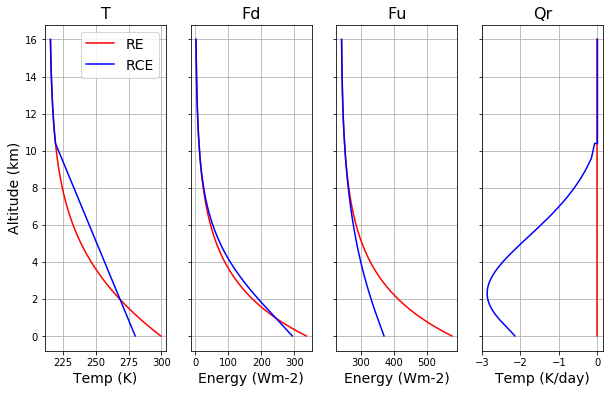

In [30]:
fig, ax = plt.subplots(ncols = 4, figsize = (10,6))

ax[0].plot(T_m_RE_zs, RE_zs/1000, 'r', T_m_adj_new_zs, RCE_zs/1000, 'b')
#plt.plot(T_surf, tao_values)
ax[0].set_title('T', fontsize = 16)
ax[0].set_xlabel('Temp (K)', fontsize = 14)
ax[0].set_ylabel('Altitude (km)', fontsize = 14);
ax[0].grid()
#ax.set_ylim(0, 20);
#ax.set_xlim(150, 350)
#plt.axhline(y = pi_B_sfc, color = 'k', linewidth = 1.5, linestyle = '--')
#plt.axhline(y = pi_B_above, color = 'k', linewidth = 1.5, linestyle = ':')
#plt.axhline(y = So, color = 'k', linewidth = 1.5, linestyle = '-.')
ax[0].legend(['RE', 'RCE'], fontsize = 14)

ax[1].plot(Fd_RE_zs, RE_zs/1000, 'r', Fd_zs, RCE_zs/1000, 'b')
#plt.plot(T_surf, tao_values)
ax[1].set_title('Fd', fontsize = 16)
ax[1].set_xlabel('Energy (Wm-2)', fontsize = 14)
ax[1].set_ylabel(' ', fontsize = 14);
ax[1].grid();
ax[1].set_yticklabels([]);
#ax.set_ylim(0, 20);
#ax.set_xlim(150, 350)
#plt.axhline(y = pi_B_sfc, color = 'k', linewidth = 1.5, linestyle = '--')
#plt.axhline(y = pi_B_above, color = 'k', linewidth = 1.5, linestyle = ':')
#plt.axhline(y = So, color = 'k', linewidth = 1.5, linestyle = '-.')
#ax[1].legend(['Fd', 'Fu'], fontsize = 14)

ax[2].plot(Fu_RE_zs, RE_zs/1000, 'r', Fu_zs, RCE_zs/1000, 'b')
#plt.plot(T_surf, tao_values)
ax[2].set_title('Fu', fontsize = 16)
ax[2].set_xlabel('Energy (Wm-2)', fontsize = 14)
ax[2].set_ylabel(' ', fontsize = 14);
ax[2].grid()
ax[2].set_yticklabels([]);
#ax.set_ylim(0, 20);
#ax.set_xlim(150, 350)
#plt.axhline(y = pi_B_sfc, color = 'k', linewidth = 1.5, linestyle = '--')
#plt.axhline(y = pi_B_above, color = 'k', linewidth = 1.5, linestyle = ':')
#plt.axhline(y = So, color = 'k', linewidth = 1.5, linestyle = '-.')
#ax[2].legend(['Fu'], fontsize = 14)

ax[3].plot(QR_RE, RE_zs/1000, 'r', QR, RCE_zs/1000, 'b')
#plt.plot(T_surf, tao_values)
ax[3].set_title('Qr', fontsize = 16)
ax[3].set_xlabel('Temp (K/day)', fontsize = 14)
ax[3].set_ylabel(' ', fontsize = 14);
ax[3].grid()
ax[3].set_yticklabels([]);

#fig.savefig('climate_dynamics_fig_1bi.png')

In [31]:
# Take difference between top and bottom Fu and Fd for both solutions 
len(Fu)

101

In [32]:
## RCE 
(Fd[-1] - Fu[-1]) - (Fd[0]-Fu[0])

-163.41205298596293

In [37]:
## RE 
#(Fd[-1] - Fu[-1]) - (Fd[0]-Fu[0])
(Fd_RE_zs[RE_zs<10338.4][-1] - Fu_RE_zs[RE_zs<10338.4][-1]) - (Fd_RE_zs[RE_zs<10338.4][0] - Fu_RE_zs[RE_zs<10338.4][0])

0.0

In [38]:
# RCE net radiative flux into the surface 
Fd[0]-Fu[0]

-76.58794641908742

In [39]:
# RE net radiative flux into the surface 
Fd_RE_zs[RE_zs<10338.4][0] - Fu_RE_zs[RE_zs<10338.4][0]

-240.0

Part C


In [42]:
# create taus from RE_zs 
RCE_taus = tau_inf*(1 - np.exp(-RE_zs/h))
len(RCE_taus)

201

In [43]:
Wz = np.exp(RCE_taus - tau_inf) * np.gradient(RCE_taus, RE_zs)

In [44]:
f_OLR_RCE = (sigma * T_m_adj_new_zs**4 * Wz * h) / 240
f_OLR_RE = (sigma * T_m_RE_zs**4 * Wz * h) / 240

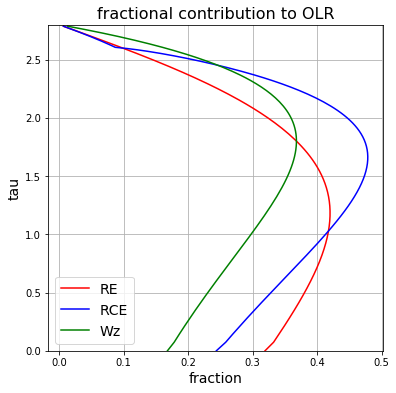

In [62]:
fig, ax = plt.subplots(figsize = (6,6))

ax.plot(f_OLR_RE, RCE_taus, 'r', f_OLR_RCE, RCE_taus, 'b', Wz*h, RCE_taus, 'g')
#plt.plot(T_surf, tao_values)
ax.set_title('fractional contribution to OLR', fontsize = 16)
ax.set_xlabel('fraction', fontsize = 14)
ax.set_ylabel('tau', fontsize = 14);
ax.grid()
ax.set_ylim(0, tau_inf);
ax.legend(['RE', 'RCE', 'Wz'], fontsize = 14);

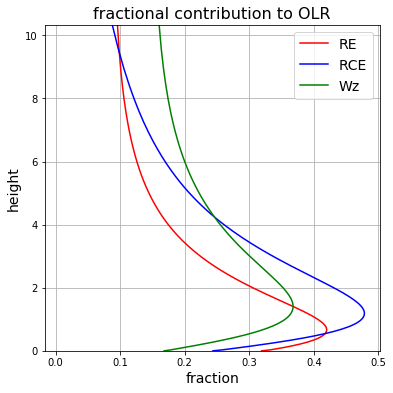

In [63]:
fig, ax = plt.subplots(figsize = (6,6))

ax.plot(f_OLR_RE, RCE_zs/1000, 'r', f_OLR_RCE, RCE_zs/1000, 'b', Wz*h, RCE_zs/1000, 'g')
#plt.plot(T_surf, tao_values)
ax.set_title('fractional contribution to OLR', fontsize = 16)
ax.set_xlabel('fraction', fontsize = 14)
ax.set_ylabel('height', fontsize = 14);
ax.grid()
#plt.axhline(y = 10.3384, color = 'k', linewidth = 1.5, linestyle = '--')
ax.set_ylim(0, 10.3384);
ax.legend(['RE', 'RCE', 'Wz'], fontsize = 14);

c. iii.
Is W(z) largest where tau differs by unity from its TOA value (tau_inf), as previously derived?

W(z) is largest just below the top of the mixed layer. 

Why is the largest contribution to OLR coming from a height that differs from where W(z) is largest?

The largest contribution to OLR is coming from a height that differes from where W(z) is largest because...

Why is the largest contribution to OLR in the radiative equilibrium coming from a lower level than the largest contribution in radiative-convective equilibrium?

Water vapor (i.e. clouds?)

c. iv.

Calculate an emitting temperature TE by equating the net absorbed solar flux So to sigmaTE^4. Is this above or below the level making the maximum contribution to OLR? Why is this? (*Hint:* Consider the surface contribution to OLR.) What if the column opacity tau_M is increased? Does TE move closer to the level making the maximum contribution to OLR? Why? 

In [66]:
Te = (So/sigma)**(1/4)
Te

255.0686277518965

In [75]:
LR_g = -g / Cp 

def get_error_partd(x):
    tau_M = tau_inf*(1 - np.exp(-x/h))
    Fd_m = So*(0.5*(tau_inf - tau_M))
    taus = np.linspace(0, tau_M, 101)
    zs = -h*(np.log(1 - (taus/tau_inf)))
    T_RE = ((So/sigma)*(0.5*(tau_inf*np.exp(-zs/h)) + 0.5))**(1/4)
    T_RCE = T_RE[-1] + LR_g*(zs-zs[-1])
    Fd = []
    for m in range(len(taus)):
        test_sum = Fd_m*np.exp(taus[m] - taus[-1]) 
        for j in range(m,100):
            test_sum += 0.5*(sigma*T_RCE[j]**4 * np.exp(taus[m] - taus[j]) + sigma*T_RCE[j+1]**4 * np.exp(taus[m] - taus[j+1])) * (taus[j+1] - taus[j])
        Fd.append(test_sum)
    T_b = (So + Fd[0] - (sigma*(T_RCE[0]**4)))/(4 * sigma * (T_RCE[0]**3) + k) + T_RCE[0]  
    Fu_sfc = sigma*(T_RCE[0]**4) + (4*sigma*(T_RCE[0]**3))*(T_b - T_RCE[0])
    Fu = []
    for m in reversed(range(len(taus))):
        test_sum_Fu = Fu_sfc*np.exp(-1*taus[m])
        for j in range(m):
            test_sum_Fu += 0.5*(sigma*(T_RCE[j]**4) * np.exp(taus[j] - taus[m]) + sigma*(T_RCE[j+1]**4) * np.exp(taus[j+1] - taus[m])) * (taus[j+1] - taus[j])
        Fu.append(test_sum_Fu)
    Fu = Fu[::-1]
    Fu_RE = So*(0.5*(tau_inf - taus[-1]) + 1)
    #Fd_RE = So*(0.5*(tau_inf - taus))
    error = Fu[-1] - Fu_RE
    
    #return(error)
    return(error,taus,zs,T_RE,T_RCE,Fd,Fu)

In [76]:
a = 5000
b = 30000

c = a 
while ((b-a) >= 0.0001): 

    # Find middle point 
    c = (a+b)/2

    # Check if middle point is root 
    if (get_error_partd(c)[0] == 0.0): 
        break

    # Decide the side to repeat the steps 
    if (get_error_partd(c)[0]*get_error_partd(a)[0] < 0): 
        b = c 
    else: 
        a = c 

print("The value of root is : ","%.4f"%c) 
error,taus,zs,T_RE,T_RCE,Fd,Fu  = get_error_partd(c)

The value of root is :  6196.9459


The mixed-layer depth using a drya adiabatic lapse rate is *6196.95 m*.

Part e. Return to a 'moist' lapse rate. 

i. What is the tropopause height assuming that the scale height of the longwave absorber is 0.5 km?

In [84]:
# change absorber scale height from h = 3 km to h = 0.5 km
h = 0.5*1000
def get_error_parte(x):
    tau_M = tau_inf*(1 - np.exp(-x/h))
    Fd_m = So*(0.5*(tau_inf - tau_M))
    taus = np.linspace(0, tau_M, 101)
    zs = -h*(np.log(1 - (taus/tau_inf)))
    T_RE = ((So/sigma)*(0.5*(tau_inf*np.exp(-zs/h)) + 0.5))**(1/4)
    T_RCE = T_RE[-1] + LR*(zs-zs[-1])
    Fd = []
    for m in range(len(taus)):
        test_sum = Fd_m*np.exp(taus[m] - taus[-1]) 
        for j in range(m,100):
            test_sum += 0.5*(sigma*T_RCE[j]**4 * np.exp(taus[m] - taus[j]) + sigma*T_RCE[j+1]**4 * np.exp(taus[m] - taus[j+1])) * (taus[j+1] - taus[j])
        Fd.append(test_sum)
    T_b = (So + Fd[0] - (sigma*(T_RCE[0]**4)))/(4 * sigma * (T_RCE[0]**3) + k) + T_RCE[0]  
    Fu_sfc = sigma*(T_RCE[0]**4) + (4*sigma*(T_RCE[0]**3))*(T_b - T_RCE[0])
    Fu = []
    for m in reversed(range(len(taus))):
        test_sum_Fu = Fu_sfc*np.exp(-1*taus[m])
        for j in range(m):
            test_sum_Fu += 0.5*(sigma*(T_RCE[j]**4) * np.exp(taus[j] - taus[m]) + sigma*(T_RCE[j+1]**4) * np.exp(taus[j+1] - taus[m])) * (taus[j+1] - taus[j])
        Fu.append(test_sum_Fu)
    Fu = Fu[::-1]
    Fu_RE = So*(0.5*(tau_inf - taus[-1]) + 1)
    #Fd_RE = So*(0.5*(tau_inf - taus))
    error = Fu[-1] - Fu_RE
    
    #return(error)
    return(error,taus,zs,T_RE,T_RCE,Fd,Fu)

In [78]:
a = 5000
b = 30000

c = a 
while ((b-a) >= 0.0001): 

    # Find middle point 
    c = (a+b)/2

    # Check if middle point is root 
    if (get_error_parte(c)[0] == 0.0): 
        break

    # Decide the side to repeat the steps 
    if (get_error_parte(c)[0]*get_error_parte(a)[0] < 0): 
        b = c 
    else: 
        a = c 

print("The value of root is : ","%.4f"%c) 
error,taus,zs,T_RE,T_RCE,Fd,Fu  = get_error_parte(c)

The value of root is :  7706.3861


The tropopause height assuming that the scale height of the longwave absorber is 0.5 km is *7706.39 m*.

ii. What is the tropopause height assuming that the scale height of the longwave absorber is 6 km?

In [85]:
# change absorber scale height from h = 3 km to h = 0.5 km
h = 6*1000
def get_error_parte(x):
    tau_M = tau_inf*(1 - np.exp(-x/h))
    Fd_m = So*(0.5*(tau_inf - tau_M))
    taus = np.linspace(0, tau_M, 101)
    zs = -h*(np.log(1 - (taus/tau_inf)))
    T_RE = ((So/sigma)*(0.5*(tau_inf*np.exp(-zs/h)) + 0.5))**(1/4)
    T_RCE = T_RE[-1] + LR*(zs-zs[-1])
    Fd = []
    for m in range(len(taus)):
        test_sum = Fd_m*np.exp(taus[m] - taus[-1]) 
        for j in range(m,100):
            test_sum += 0.5*(sigma*T_RCE[j]**4 * np.exp(taus[m] - taus[j]) + sigma*T_RCE[j+1]**4 * np.exp(taus[m] - taus[j+1])) * (taus[j+1] - taus[j])
        Fd.append(test_sum)
    T_b = (So + Fd[0] - (sigma*(T_RCE[0]**4)))/(4 * sigma * (T_RCE[0]**3) + k) + T_RCE[0]  
    Fu_sfc = sigma*(T_RCE[0]**4) + (4*sigma*(T_RCE[0]**3))*(T_b - T_RCE[0])
    Fu = []
    for m in reversed(range(len(taus))):
        test_sum_Fu = Fu_sfc*np.exp(-1*taus[m])
        for j in range(m):
            test_sum_Fu += 0.5*(sigma*(T_RCE[j]**4) * np.exp(taus[j] - taus[m]) + sigma*(T_RCE[j+1]**4) * np.exp(taus[j+1] - taus[m])) * (taus[j+1] - taus[j])
        Fu.append(test_sum_Fu)
    Fu = Fu[::-1]
    Fu_RE = So*(0.5*(tau_inf - taus[-1]) + 1)
    #Fd_RE = So*(0.5*(tau_inf - taus))
    error = Fu[-1] - Fu_RE
    
    #return(error)
    return(error,taus,zs,T_RE,T_RCE,Fd,Fu)

In [80]:
a = 5000
b = 30000

c = a 
while ((b-a) >= 0.0001): 

    # Find middle point 
    c = (a+b)/2

    # Check if middle point is root 
    if (get_error_parte(c)[0] == 0.0): 
        break

    # Decide the side to repeat the steps 
    if (get_error_parte(c)[0]*get_error_parte(a)[0] < 0): 
        b = c 
    else: 
        a = c 

print("The value of root is : ","%.4f"%c) 
error,taus,zs,T_RE,T_RCE,Fd,Fu  = get_error_parte(c)

The value of root is :  9722.8857


The tropopause height assuming that the scale height of the longwave absorber is 3 km but tau_inf is 6 is *9722.89 m*.

iii. What is the tropopause height assuming that the scale height of the longwave absorber is 3 km but tau_inf = 6?

In [91]:
# change absorber scale height from h = 3 km to h = 0.5 km
tau_inf = 6
h = 3*1000
def get_error_parte(x):
    tau_M = tau_inf*(1 - np.exp(-x/h))
    Fd_m = So*(0.5*(tau_inf - tau_M))
    taus = np.linspace(0, tau_M, 101)
    zs = -h*(np.log(1 - (taus/tau_inf)))
    T_RE = ((So/sigma)*(0.5*(tau_inf*np.exp(-zs/h)) + 0.5))**(1/4)
    T_RCE = T_RE[-1] + LR*(zs-zs[-1])
    Fd = []
    for m in range(len(taus)):
        test_sum = Fd_m*np.exp(taus[m] - taus[-1]) 
        for j in range(m,100):
            test_sum += 0.5*(sigma*T_RCE[j]**4 * np.exp(taus[m] - taus[j]) + sigma*T_RCE[j+1]**4 * np.exp(taus[m] - taus[j+1])) * (taus[j+1] - taus[j])
        Fd.append(test_sum)
    T_b = (So + Fd[0] - (sigma*(T_RCE[0]**4)))/(4 * sigma * (T_RCE[0]**3) + k) + T_RCE[0]  
    Fu_sfc = sigma*(T_RCE[0]**4) + (4*sigma*(T_RCE[0]**3))*(T_b - T_RCE[0])
    Fu = []
    for m in reversed(range(len(taus))):
        test_sum_Fu = Fu_sfc*np.exp(-1*taus[m])
        for j in range(m):
            test_sum_Fu += 0.5*(sigma*(T_RCE[j]**4) * np.exp(taus[j] - taus[m]) + sigma*(T_RCE[j+1]**4) * np.exp(taus[j+1] - taus[m])) * (taus[j+1] - taus[j])
        Fu.append(test_sum_Fu)
    Fu = Fu[::-1]
    Fu_RE = So*(0.5*(tau_inf - taus[-1]) + 1)
    #Fd_RE = So*(0.5*(tau_inf - taus))
    error = Fu[-1] - Fu_RE
    
    #return(error)
    return(error,taus,zs,T_RE,T_RCE,Fd,Fu)

In [92]:
a = 5000
b = 30000

c = a 
while ((b-a) >= 0.0001): 

    # Find middle point 
    c = (a+b)/2

    # Check if middle point is root 
    if (get_error_parte(c)[0] == 0.0): 
        break

    # Decide the side to repeat the steps 
    if (get_error_parte(c)[0]*get_error_parte(a)[0] < 0): 
        b = c 
    else: 
        a = c 

print("The value of root is : ","%.4f"%c) 
error,taus,zs,T_RE,T_RCE,Fd,Fu  = get_error_parte(c)

The value of root is :  12663.9204


The tropopause height assuming that the scale height of the longwave absorber is 3 km but tau_inf is 6 is *12663.92 m*.

In [7]:
# 1.a.i
# z = 10*1000 # in m THIS IS WHERE WE WANT TO LOOP
tau_M = tau_inf*(1 - np.exp(-z/h))
tau_M

2.700112818627693

In [9]:
# 1.a.ii
tau = np.linspace(0,tau_M, npts)
tau

array([0.        , 0.27001128, 0.54002256, 0.81003385, 1.08004513,
       1.35005641, 1.62006769, 1.89007897, 2.16009025, 2.43010154,
       2.70011282])

In [10]:
z_m = []
for t in np.linspace(0, tau_M, len(tau)):
    z_calc_test = -h*(np.log(1 - (t/tau_inf)))
    z_m.append(z_calc_test)
z_m

[-0.0,
 304.21372105790374,
 642.7937636884712,
 1024.5053592681377,
 1461.964090770453,
 1974.2842934414464,
 2592.4870372588625,
 3372.0506519342234,
 4428.142659116738,
 6072.438455625237,
 10000.0]

In [11]:
# 1.a.iii
T_m = []
for l in (z_m):
    T = ((So/sigma)*(0.5*(tau_inf*np.exp(-l/h)) + 0.5))**(1/4)
    T_m.append(T)
T_m

[299.46456866315015,
 293.99698464746103,
 288.2061177367317,
 282.04351264217644,
 275.4482207719673,
 268.3419479157948,
 260.62153528098753,
 252.1467642407374,
 242.7194243561398,
 232.04469359420852,
 219.65271815609287]

In [12]:
T_m_adj = T_m[-1] + LR*(z_m-z_m[-1]) # calculated adjusted temperature with dynamically relaxed lapse rate T
T_m_adj

array([278.27821616, 276.49474807, 274.50980571, 272.27200247,
       269.70737887, 266.70387617, 263.0796318 , 258.50940129,
       252.3180093 , 242.67824331, 219.65271816])

In [13]:
# 1.a.iv.
# define f_d
Fd = So*(0.5*(tau_inf - tau_M))
Fd

11.986461764676815

In [27]:
# 1.a.iv.
Fd_int = []
for m in range(0, len(tau)-1,1):
    test_sum = Fd*np.exp(tau[m] - tau[-1]) 
    for j in range(m,10):
        test_sum += 0.5*(sigma*T_m_adj[j]**4 * np.exp(tau[m] - tau[j]) + sigma*T_m_adj[j+1]**4 * np.exp(tau[m] - tau[j+1])) * (tau[j+1] - tau[j])
    Fd_int.append(test_sum)    
Fd_int.append(Fd)

In [28]:
Fd_int

[288.5573952849865,
 273.13211638004265,
 255.72306887854103,
 235.98263519124538,
 213.51999156373574,
 187.9159054361237,
 158.76216083115983,
 125.7558105398632,
 88.92921331749068,
 49.30218028105156,
 11.986461764676815]

In [16]:
T_b = (So + Fd_int[0] - (sigma*(T_m_adj[0]**4)))/(4 * sigma * (T_m_adj[0]**3) + k) + T_m_adj[0]  
T_b

282.7793507426883

In [17]:
# calc upward longwave flux at the surface 
Fu_sfc = sigma*(T_m_adj[0]**4) + (4*sigma*(T_m_adj[0]**3))*(T_b - T_m_adj[0])
Fu_sfc

362.0154158757774

In [18]:
Fu_int = []
test_sum_Fu = Fu_sfc*np.exp(-tau)
for m in range(len(tau)-1, 0, -1):
    test_sum_Fu_test = 0
    for j in range(1,m+1):
        test_sum_Fu_test += 0.5*(sigma*(T_m_adj[j]**4) * np.exp(tau[j] - tau[m]) + sigma*(T_m_adj[j-1]**4) * np.exp(tau[j-1] - tau[m])) * (tau[j] - tau[j-1])
    Fu_int.append(test_sum_Fu_test+test_sum_Fu[m])

Fu_int.append(Fu_sfc)
Fu_int = Fu_int[::-1]
Fu_int

[362.0154158757774,
 356.1325214503853,
 349.48102801550993,
 342.033119519753,
 333.7160253279469,
 324.39969386937776,
 313.8706779890539,
 301.7761785012528,
 287.48942302510835,
 269.69514063008455,
 243.96354269599075]

In [19]:
Fu_RE = So*(0.5*(tau_inf - tau[-1]) + 1)
Fu_RE

251.98646176467682

In [20]:
Fu_error = Fu_int[-1] - Fu_RE
Fu_error

-8.022919068686065